In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
inspections = pd.read_pickle('/home/michael/chicagohealthinspections/data/inspectdata.pkl')
locations = pd.read_pickle('/home/michael/chicagohealthinspections/data/linkloc.pkl')
businesses = pd.read_pickle('/home/michael/chicagohealthinspections/data/businesses.pkl')
category = pd.read_pickle('/home/michael/chicagohealthinspections/data/categories.pkl')
#violations = pd.read_pickle('/home/michael/chicagohealthinspections/data/violations.pkl')

# 4.0 Data Exploration
## 4.1 Clean up inspection data
I converted fields into numeric for modeling and added number values for the string fields

In [3]:
inspections['license'] = np.where(inspections['Inspection Type'].str.contains('License'),1,0)
inspections = inspections[inspections['license']==0]

In [4]:
inspections['y'] = np.where(inspections['Results']=='Fail',1,0)
inspections['inspcount'] = inspections.groupby('LocId').cumcount() + 1

In [5]:
inspections['prevfails'] = inspections.groupby('LocId')[['y']].cumsum()
inspections['prevfails'] = inspections['prevfails'] - inspections['y']
inspections['failpct'] = inspections['prevfails'] / inspections['inspcount']

In [6]:
inspections['Risknbr'] = inspections['Risk'].str.slice(5,6)
inspections['Risknbr'] = inspections['Risknbr'].fillna(0)

In [8]:
simplemodel = pd.merge(inspections[['y','Inspection Type','Results',
                                    'LocId','inspcount','prevfails',
                                    'failpct','Risknbr']],
                    locations[['LocId','id','PRI_NEIGH']],
                    how='inner')
simplemodel = pd.merge(simplemodel,
                    businesses[['id','price','rating','review_count']],
                    how='inner')
simplemodel = simplemodel[['y','Inspection Type','price','rating',
                           'review_count','inspcount','prevfails',
                           'failpct','Risknbr']]
simplemodel['price'] = [x.count('$') for x in simplemodel['price']]

In [9]:
simplemodel['complaint'] = np.where((simplemodel['Inspection Type'].str.contains('Complaint'))
                                    |(simplemodel['Inspection Type'].str.contains('Poisoning')),1,0)
simplemodel['reinspection'] = np.where(simplemodel['Inspection Type'].str.contains('nspection'),1,0)

In [10]:
simplemodel.head()

,y,Inspection Type,price,rating,review_count,inspcount,prevfails,failpct,Risknbr,complaint,reinspection
0,0,Suspected Food Poisoning,1,2.0,320.0,1,0,0.0,1,1,0
1,0,Short Form Complaint,1,2.0,320.0,2,0,0.0,1,1,0
2,0,Complaint,1,2.0,320.0,3,0,0.0,1,1,0
3,1,Complaint,1,2.0,320.0,4,0,0.0,1,1,0
4,0,Complaint Re-Inspection,1,2.0,320.0,5,1,0.2,1,1,1


In [11]:
simplemodel.groupby('Inspection Type')[['complaint','reinspection','y']].sum()

,complaint,reinspection,y
Inspection Type,,,
1315 license reinspection,0,1,1
CANVAS,0,0,0
CANVASS FOR RIB FEST,0,0,0
CANVASS RE INSPECTION OF CLOSE UP,0,0,0
CHANGED COURT DATE,0,0,0
Canvass,0,0,8838
Canvass Re-Inspection,0,10242,503
Complaint,10401,0,3352
Complaint Re-Inspection,4148,4148,325


In [12]:
rf = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=2,
                           n_jobs=-1,
                           class_weight='balanced')

In [13]:
X_train = simplemodel.drop(['Inspection Type','review_count'],1)
target = X_train.pop('y')
rf.fit(X_train,target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [14]:
rf.feature_importances_

array([ 0.08345494,  0.2449797 ,  0.19383497,  0.05954854,  0.14951762,
        0.0455786 ,  0.02485261,  0.19823301])

In [15]:
X_train.head()

,price,rating,inspcount,prevfails,failpct,Risknbr,complaint,reinspection
0,1,2.0,1,0,0.0,1,1,0
1,1,2.0,2,0,0.0,1,1,0
2,1,2.0,3,0,0.0,1,1,0
3,1,2.0,4,0,0.0,1,1,0
4,1,2.0,5,1,0.2,1,1,1


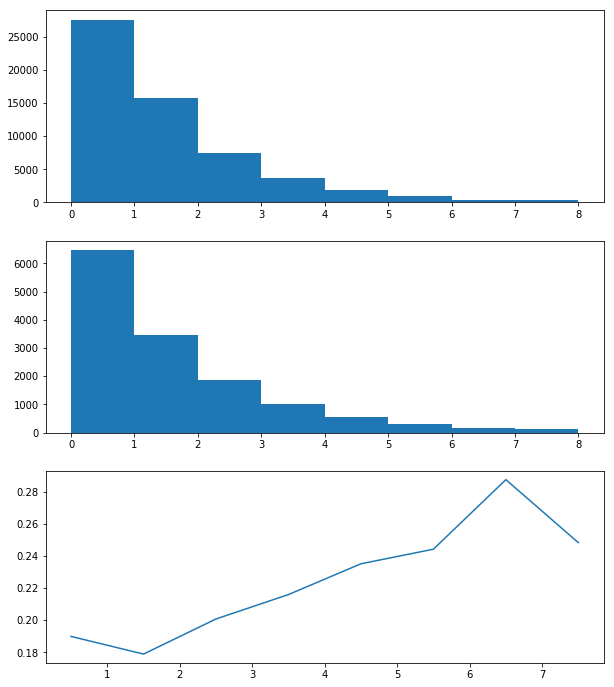

In [246]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'prevfails'], bins=8, range=(0,8))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'prevfails'], bins=8, range=(0,8))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

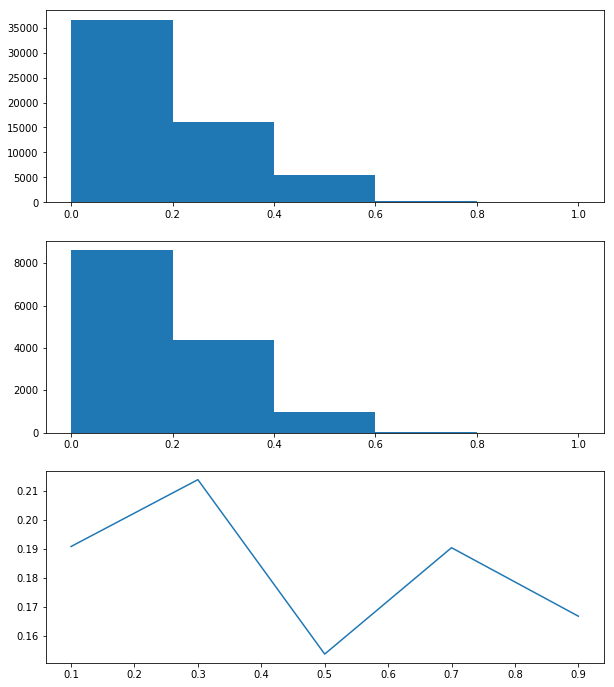

In [247]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'failpct'], bins=5, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'failpct'], bins=5, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

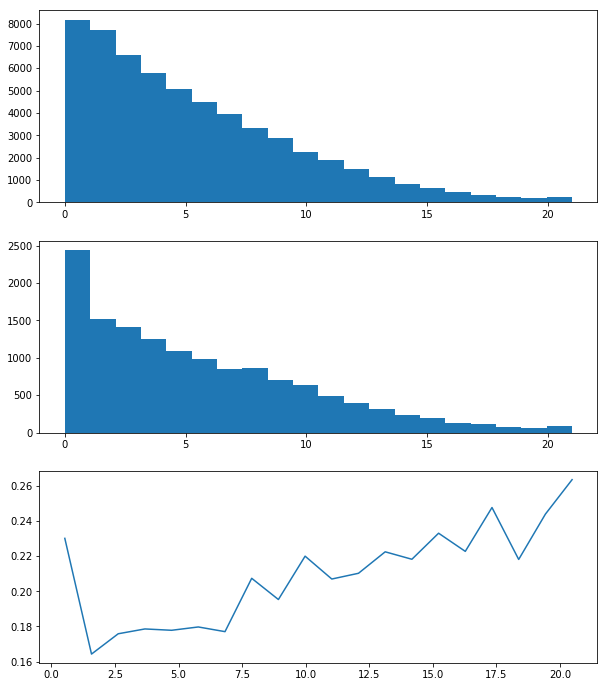

In [248]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'inspcount'], bins=20, range=(0,21))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'inspcount'], bins=20, range=(0,21))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

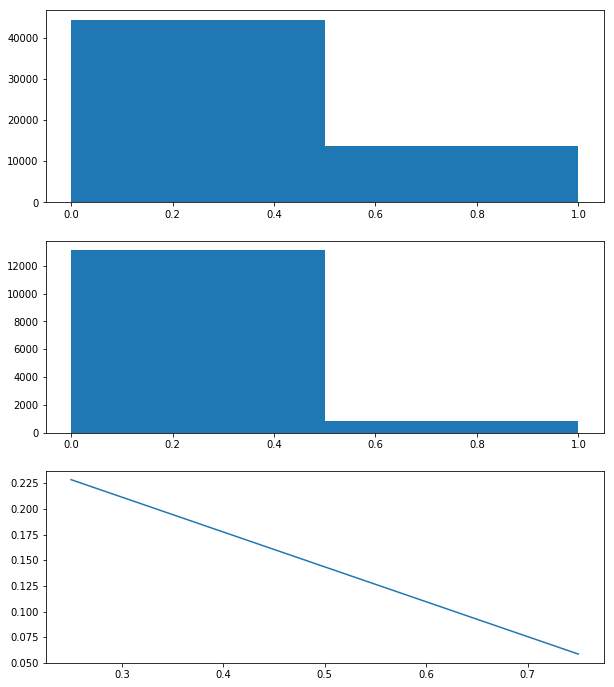

In [249]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'reinspection'], bins=2, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'reinspection'], bins=2, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

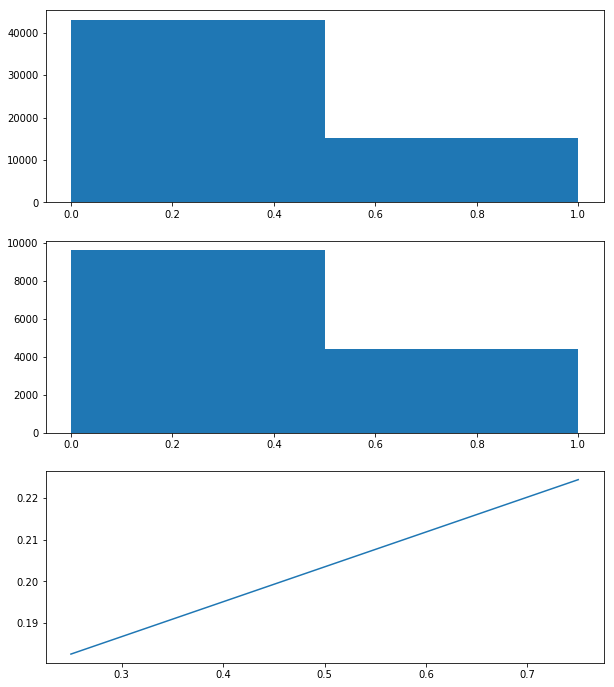

In [250]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'complaint'], bins=2, range=(0,1))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'complaint'], bins=2, range=(0,1))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

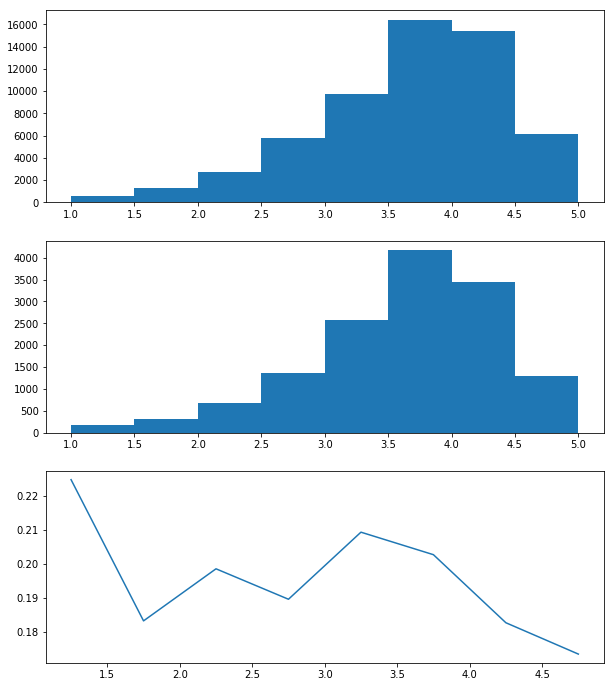

In [251]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'rating'], bins=8, range=(1,5))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'rating'], bins=8, range=(1,5))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

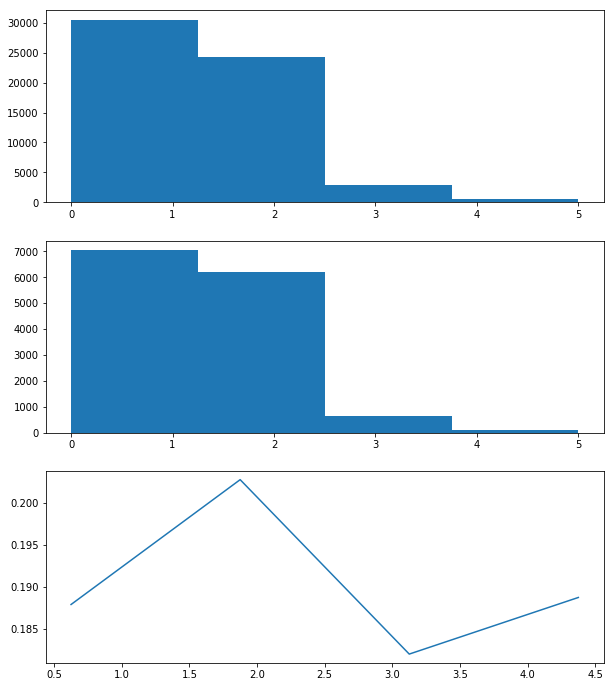

In [252]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))  # 3 Rows, 1 Col

count0, bins_0, _ = ax[0].hist(X_train.loc[(target==0),'price'], bins=4, range=(0,5))
count1, bins_1, _ = ax[1].hist(X_train.loc[(target==1),'price'], bins=4, range=(0,5))
ax[2].plot((bins_0[:-1]+bins_0[1:])/2,count1/(count1 + count0));

## 4.3 Categories 
So first I pulled in categories and did a random forest for important features for my target y

In [20]:
category.head()

,id,alias,title,catid
0,1-chop-suey-chicago,chinese,Chinese,1
1,1000-liquors-chicago-2,beer_and_wine,"Beer, Wine & Spirits",2
2,1048-sky-lounge-wrigley-rooftop-chicago-4,stadiumsarenas,Stadiums & Arenas,3
3,1048-sky-lounge-wrigley-rooftop-chicago-4,venues,Venues & Event Spaces,4
4,10pin-bowling-lounge-chicago,bowling,Bowling,5


In [64]:
topcats = category.groupby('alias',as_index=False)[['id']].count().sort_values('id',ascending=False).head(25)
catlist = [x for x in topcats['alias']]
catdummy = category.copy(deep=True)
catdummy['cleancat'] = np.where(catdummy['alias'].isin(catlist),catdummy['alias'],'other')
dummys = pd.get_dummies(catdummy['cleancat'])
catdummy = catdummy.merge(dummys, how ='inner',right_index=True,left_index=True)
catdummy = catdummy.drop(['alias','title','catid','cleancat'],axis=1)
catdummy.head()

,id,bakeries,bars,beer_and_wine,breakfast_brunch,burgers,cafes,chicken_wings,childcare,chinese,...,newamerican,other,pizza,salad,sandwiches,seafood,sportsbars,sushi,thai,tradamerican
0,1-chop-suey-chicago,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1000-liquors-chicago-2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1048-sky-lounge-wrigley-rooftop-chicago-4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1048-sky-lounge-wrigley-rooftop-chicago-4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,10pin-bowling-lounge-chicago,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [65]:
catloc = locations[['LocId','id']].copy(deep=True)
catloc = catloc.merge(catdummy, how='inner')
catinsp = pd.merge(inspections[['y','LocId']],catloc)
catinsp.head()

,y,LocId,id,bakeries,bars,beer_and_wine,breakfast_brunch,burgers,cafes,chicken_wings,...,newamerican,other,pizza,salad,sandwiches,seafood,sportsbars,sushi,thai,tradamerican
0,0,1,el-ranchito-restaurant-chicago-5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,el-ranchito-restaurant-chicago-5,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,el-ranchito-restaurant-chicago-5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,el-ranchito-restaurant-chicago-5,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,el-ranchito-restaurant-chicago-5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
catrf = RandomForestClassifier(n_estimators=1000,
                           criterion='entropy',
                           max_features=5,
                           n_jobs=-1,
                           class_weight='balanced')

In [67]:
X_train_cat = catinsp.drop(['LocId','id'],1)
target_cat = X_train_cat.pop('y')
catrf.fit(X_train_cat,target_cat)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [68]:
results = np.column_stack((X_train_cat.columns,catrf.feature_importances_))
results = results[results[:,1].argsort()][::-1]
results

array([['sandwiches', 0.18042193915371316],
       ['hotdogs', 0.15202991186804476],
       ['childcare', 0.07254446003659493],
       ['coffee', 0.06947045033305808],
       ['tradamerican', 0.06434060811580365],
       ['sportsbars', 0.06179356942369706],
       ['bars', 0.0612677921200189],
       ['chinese', 0.049170182187641805],
       ['italian', 0.038852630082939134],
       ['salad', 0.033265654125004776],
       ['bakeries', 0.030777377908763656],
       ['newamerican', 0.028232899644738452],
       ['convenience', 0.022743862307653816],
       ['thai', 0.01939290567028421],
       ['other', 0.019256246077049104],
       ['mexican', 0.015063244888061454],
       ['cafes', 0.013405305247817996],
       ['seafood', 0.011750204957325481],
       ['breakfast_brunch', 0.011525656485236312],
       ['icecream', 0.010307489742322174],
       ['burgers', 0.010061973863816057],
       ['sushi', 0.006353383565282289],
       ['pizza', 0.006043143288124274],
       ['grocery', 0.0047291